In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## File Descriptions and Data Field Information

### train.csv
- The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
- store_nbr identifies the store at which the products are sold.
- family identifies the type of product sold.
- sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
- onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

In [2]:
train = pd.read_csv('train.csv', parse_dates=['date'])
train.dtypes

id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dtype: object

In [3]:
train.groupby('store_nbr').count().describe()

,id,date,family,sales,onpromotion
count,54.0,54.0,54.0,54.0,54.0
mean,55572.0,55572.0,55572.0,55572.0,55572.0
std,0.0,0.0,0.0,0.0,0.0
min,55572.0,55572.0,55572.0,55572.0,55572.0
25%,55572.0,55572.0,55572.0,55572.0,55572.0
50%,55572.0,55572.0,55572.0,55572.0,55572.0
75%,55572.0,55572.0,55572.0,55572.0,55572.0
max,55572.0,55572.0,55572.0,55572.0,55572.0


### Each store has 55572 entries

In [4]:
train.groupby(['store_nbr', 'family']).count().describe()

,id,date,sales,onpromotion
count,1782.0,1782.0,1782.0,1782.0
mean,1684.0,1684.0,1684.0,1684.0
std,0.0,0.0,0.0,0.0
min,1684.0,1684.0,1684.0,1684.0
25%,1684.0,1684.0,1684.0,1684.0
50%,1684.0,1684.0,1684.0,1684.0
75%,1684.0,1684.0,1684.0,1684.0
max,1684.0,1684.0,1684.0,1684.0


## Total 1782 categories, or need to create 1782 models for each category

In [5]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


### MIssing Days if Any

In [6]:
from datetime import date
import numpy as np

d0 = np.sort(train['date'])[0]
d1 = np.sort(train['date'])[-1]
delta = d1 - d0
no_of_days = train['date'].nunique()
print('The number of days between the given range of dates is :')
print(delta.astype('timedelta64[D]')+1)
print(no_of_days)

The number of days between the given range of dates is :
1688 days
1684


### Find the missing Dates

In [7]:
pd.date_range(start=d0, end=d1).difference(train['date'].unique())

DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)

#### Conclusion: In Christmas, stores are always closed 

### Total Sales across Family

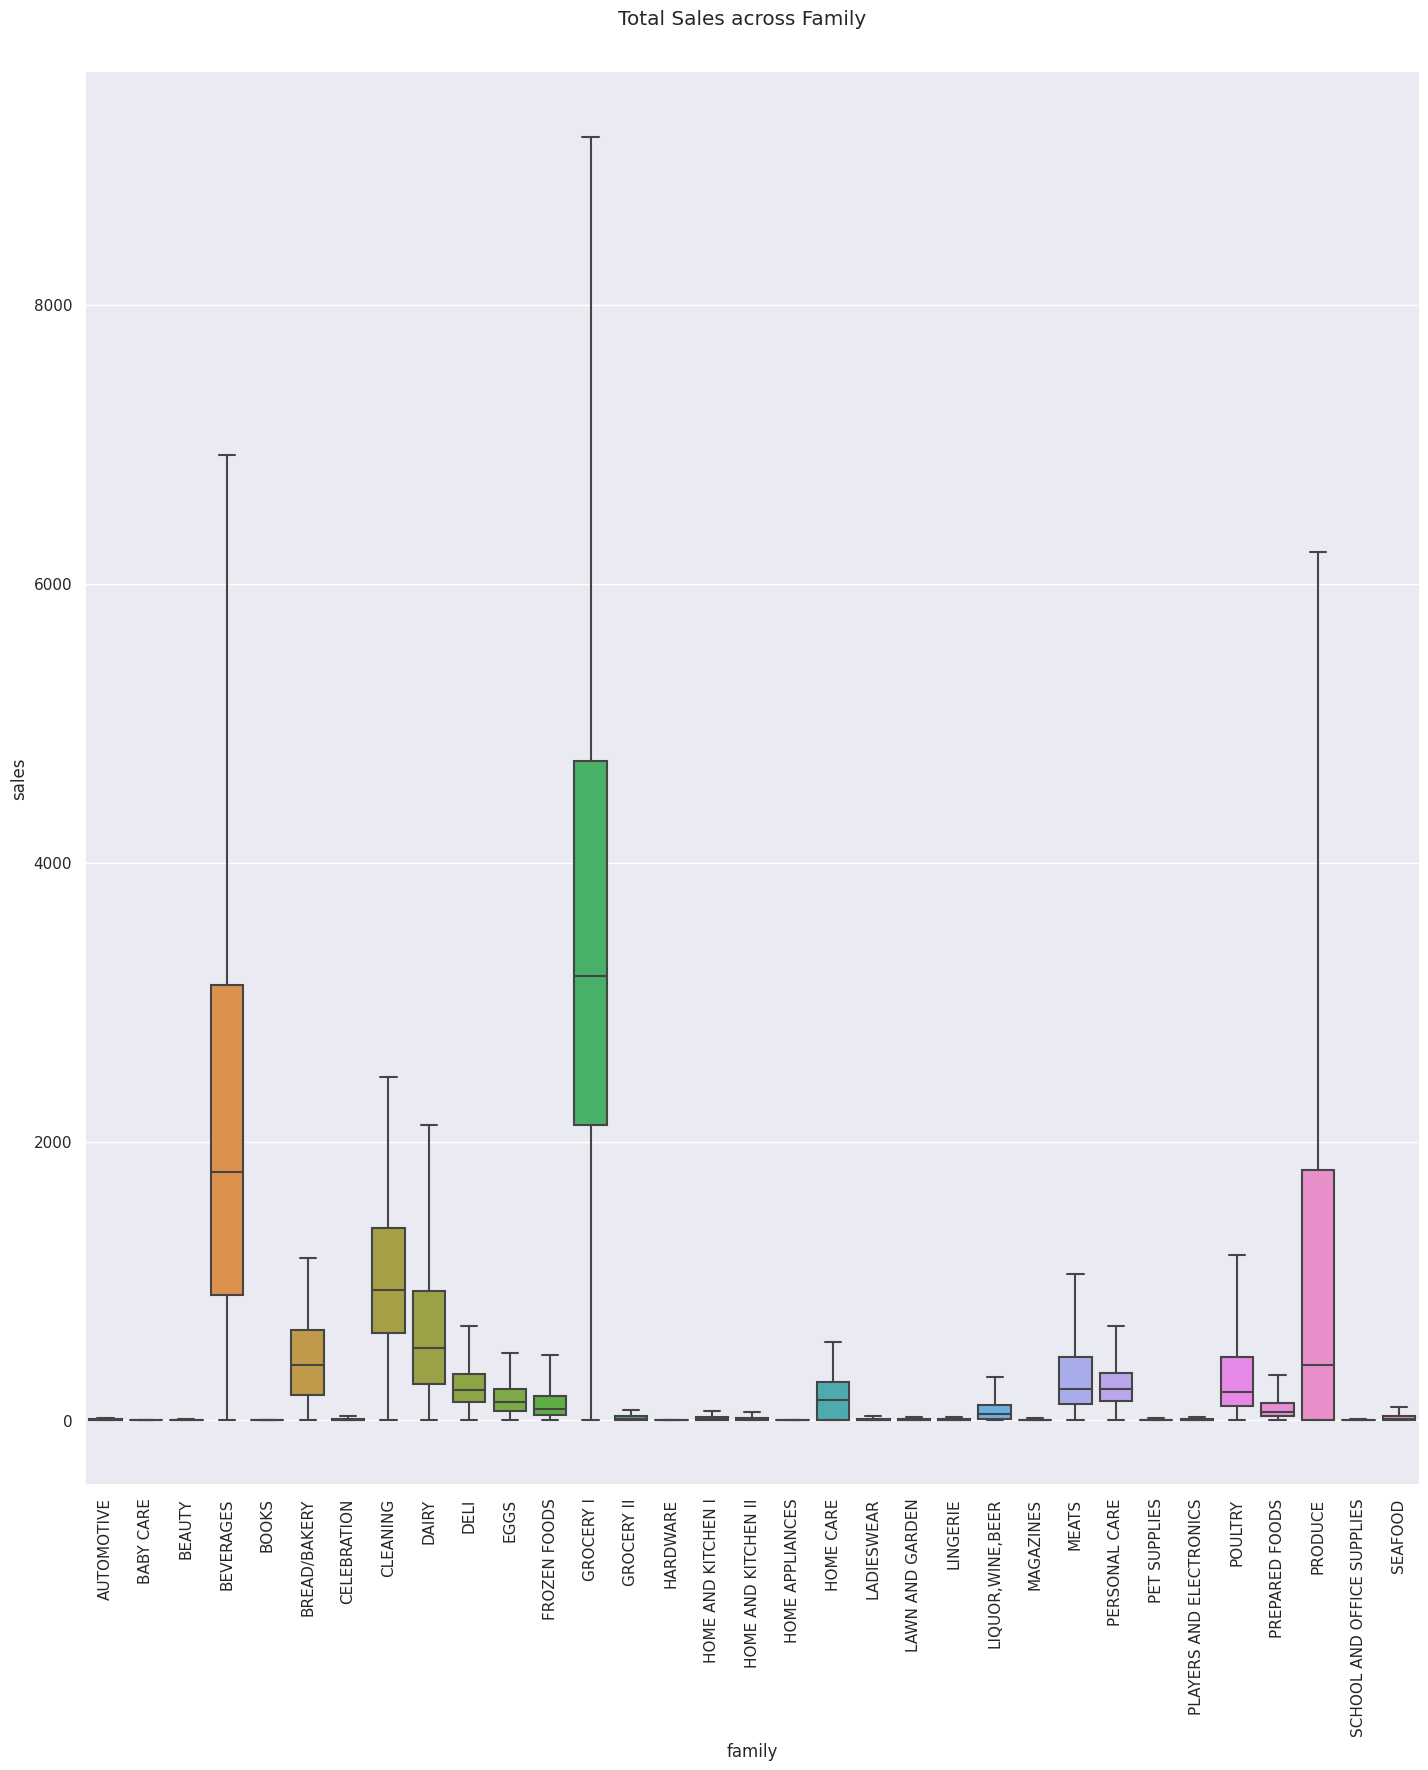

In [8]:
sns.set(rc={'figure.figsize':(20,20)})
g= sns.catplot(data=train, x='family', y='sales', kind='box', whis=[5,95], sym="", height=15, aspect=1/1
            # col=year(date), 
            # col_wrap=3
           )

g.fig.suptitle("Total Sales across Family", y=1.03)
plt.xticks(rotation=90)
plt.show()

### Total Sales across Store Number

In [9]:
print("Total stores are", train['store_nbr'].nunique())

Total stores are 54


In [10]:
# TBD

### Total Sales & Onpromotion

In [11]:
# TBD

### Time Series of Total Sales based on resampling on mean

Text(0.5, 1.03, 'Total Sales across Time')

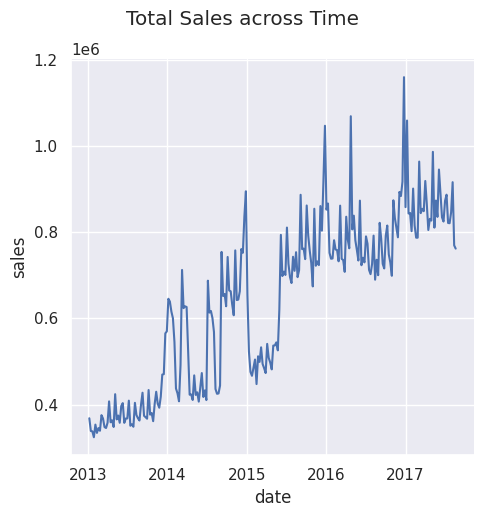

In [12]:
sns.set(rc={'figure.figsize':(12,12)})

resampled_data = train.groupby('date', as_index=False)['sales'].sum().resample('W', on='date').mean()
g = sns.relplot(x="date", y="sales", data=resampled_data, kind="line")

g.fig.suptitle("Total Sales across Time", y=1.03)

Text(0.5, 1.03, 'Total Sales across Time')

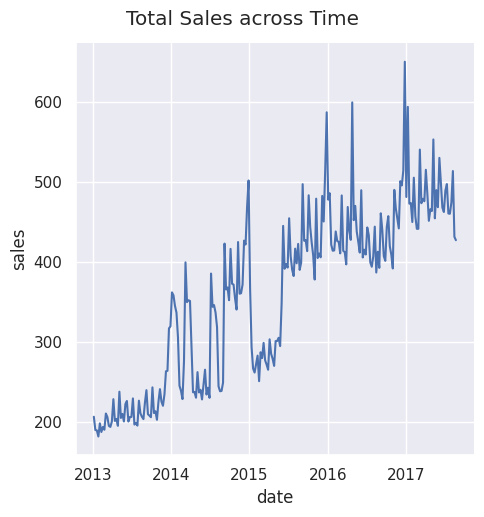

In [13]:
sns.set(rc={'figure.figsize':(12,12)})

resampled_data = train[['date', 'sales']].resample('W', on='date').mean()
g = sns.relplot(x="date", y="sales", data=resampled_data, kind="line")

g.fig.suptitle("Total Sales across Time", y=1.03)

### Singularity for Total Sales

In [14]:
import statsmodels.tsa.stattools as sts
sts.adfuller(train.groupby('date', as_index=False)['sales'].sum()['sales'])

(-2.6161957486048566,
 0.08969592175787472,
 22,
 1661,
 {'1%': -3.4342930672797065,
  '5%': -2.8632816397229064,
  '10%': -2.567697207194407},
 42848.480392783786)

#### Conclusion: Not Stationary but close to stationatity

In [15]:
## TBD

### Seasonality

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [17]:
intermediate = pd.DataFrame(train.groupby('date')['sales'].sum()).asfreq('d')
intermediate.fillna(0, inplace=True)

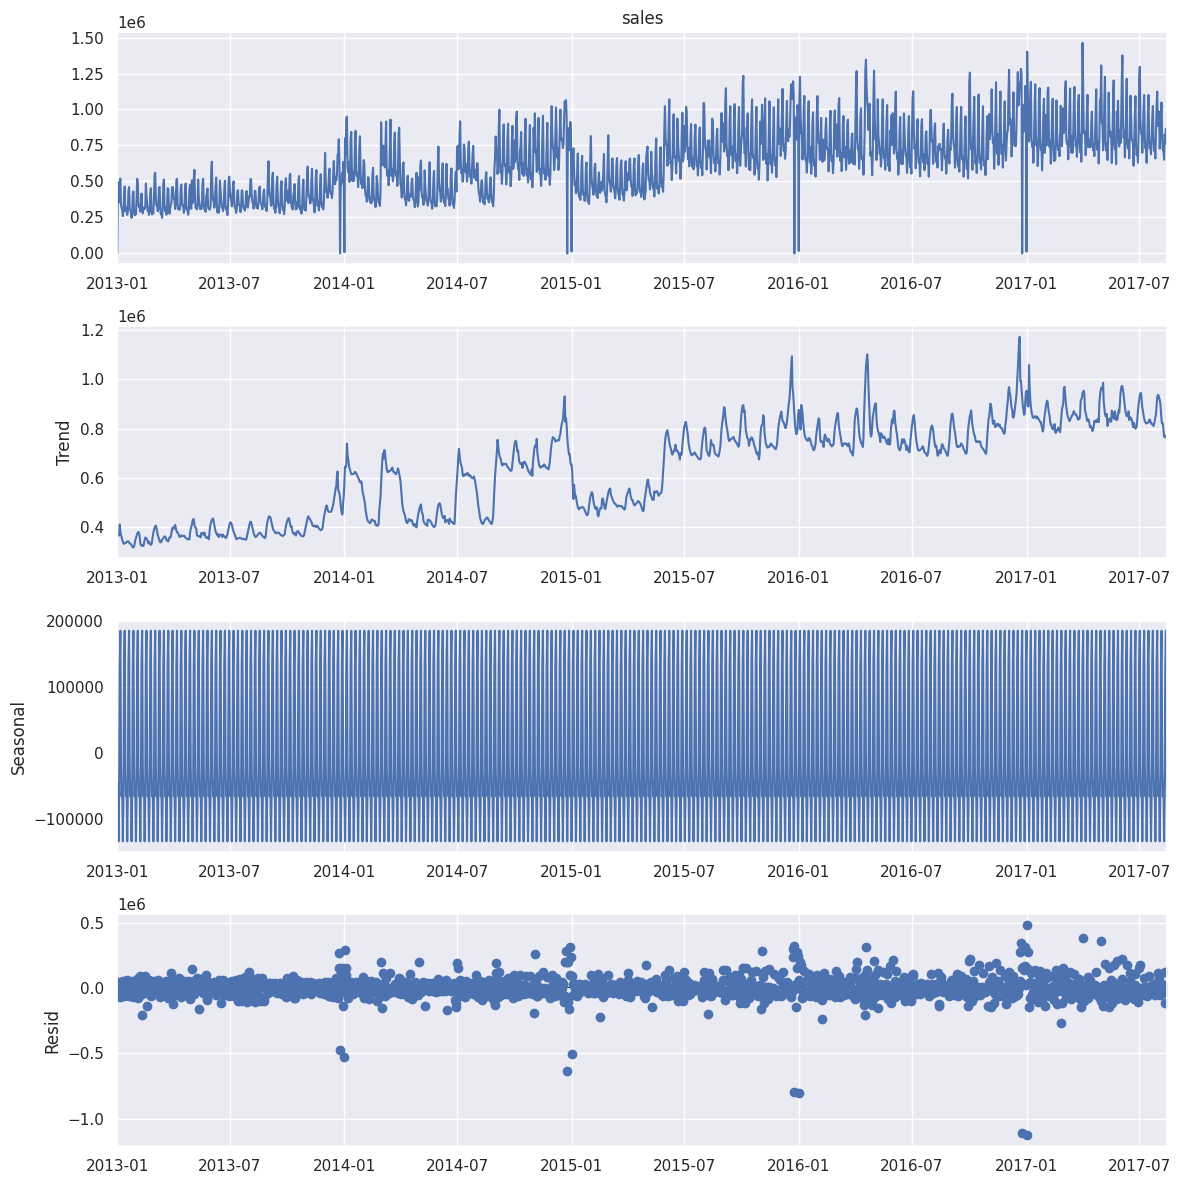

In [18]:
s_dec_additive = seasonal_decompose(intermediate['sales'] , model='additive')
s_dec_additive.plot()
plt.show()

### ACF & PACF of Total Sales Time Series

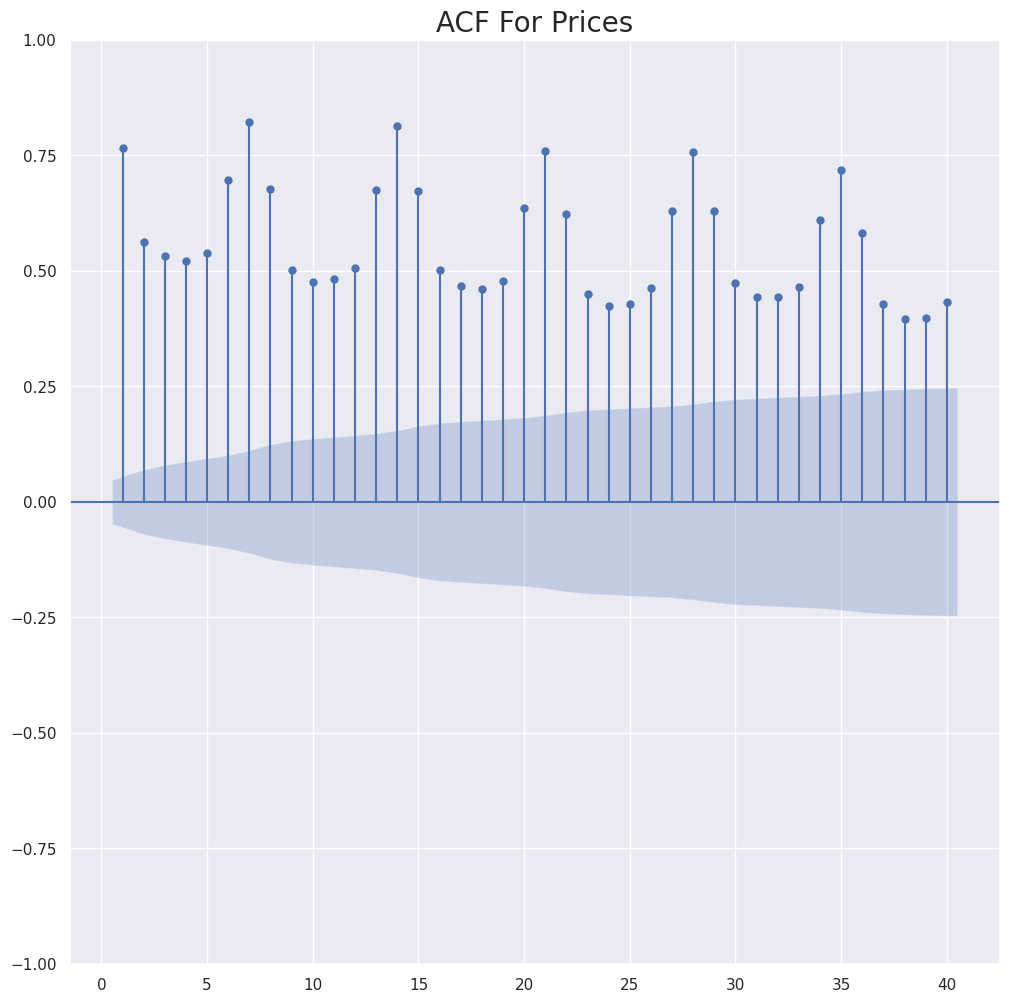

In [19]:
import statsmodels.graphics.tsaplots as sgt

sgt.plot_acf(train.groupby('date', as_index=False)['sales'].sum()['sales'], lags=40, zero=False)
plt.title("ACF For Prices", size=20)
plt.show()

#### Conclusion: 
- Dependence on weekends
- Need separate tests for Weekdays & Weeknends

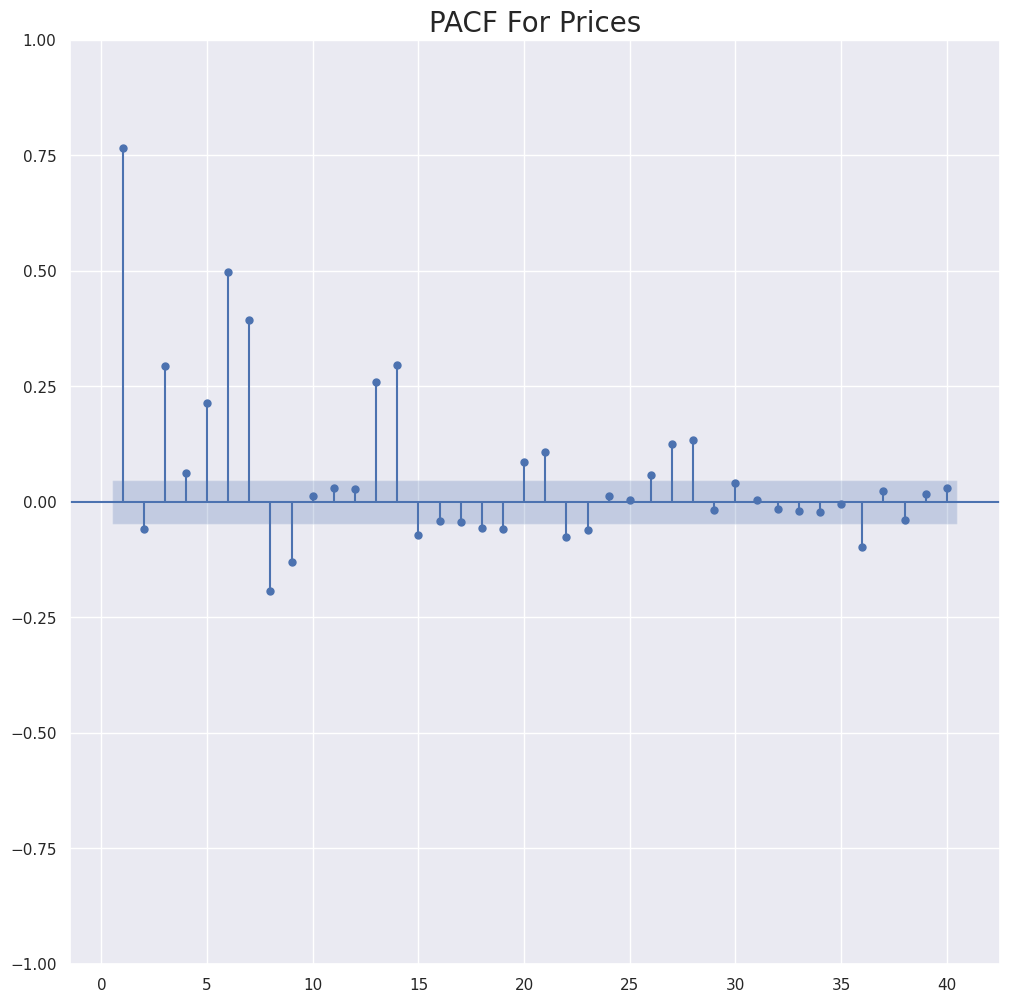

In [20]:
sgt.plot_pacf(train.groupby('date', as_index=False)['sales'].sum()['sales'], lags=40, zero=False, method='ols')
plt.title("PACF For Prices", size=20)
plt.show()

### Time Series of Total Sales after May 2017

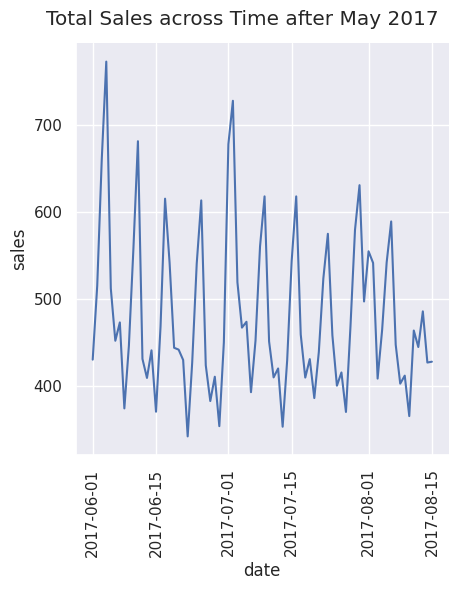

In [21]:
sns.set(rc={'figure.figsize':(12,12)})

resampled_data = train[train['date']>='2017-06-01']
g = sns.relplot(x="date", y="sales", data=resampled_data, kind="line", errorbar=None)

g.fig.suptitle("Total Sales across Time after May 2017", y=1.03)
plt.xticks(rotation=90)
plt.show()

## Last Date in Train

In [22]:
max(train['date'])

Timestamp('2017-08-15 00:00:00')

### Weekdays & Weekends

In [23]:
by_weekday = train.groupby(train['date'].dt.dayofweek)[['sales', 'onpromotion']].mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']


In [24]:
import numpy as np
weekend = np.where(train['date'].dt.weekday < 5, 'Weekday', 'Weekend')
by_weekend = train.groupby(weekend)[['sales', 'onpromotion']].mean()

by_weekend

,sales,onpromotion
Weekday,321.629081,2.831395
Weekend,448.179995,2.030972


### test.csv
- The test data, having the same features as the training data. You will predict the target sales for the dates in this file.
- The dates in the test data are for the 15 days after the last date in the training data.

In [25]:
test = pd.read_csv('test.csv', parse_dates=['date'])
test.dtypes

id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
onpromotion             int64
dtype: object

In [26]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [27]:
test.groupby('store_nbr').count().describe()

,id,date,family,onpromotion
count,54.0,54.0,54.0,54.0
mean,528.0,528.0,528.0,528.0
std,0.0,0.0,0.0,0.0
min,528.0,528.0,528.0,528.0
25%,528.0,528.0,528.0,528.0
50%,528.0,528.0,528.0,528.0
75%,528.0,528.0,528.0,528.0
max,528.0,528.0,528.0,528.0


### Test data set is from 16th August to 31st August

### sample_submission.csv
- A sample submission file in the correct format.

### stores.csv
- Store metadata, including city, state, type, and cluster.
- cluster is a grouping of similar stores.

In [28]:
stores = pd.read_csv('stores.csv')
stores.dtypes

store_nbr     int64
city         object
state        object
type         object
cluster       int64
dtype: object

In [29]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [30]:
stores.shape

(54, 5)

In [31]:
stores.cluster.nunique()

17

In [32]:
stores.city.unique()

array(['Quito', 'Santo Domingo', 'Cayambe', 'Latacunga', 'Riobamba',
       'Ibarra', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil', 'Salinas',
       'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad', 'Cuenca',
       'Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen'],
      dtype=object)

In [33]:
stores.state.unique()

array(['Pichincha', 'Santo Domingo de los Tsachilas', 'Cotopaxi',
       'Chimborazo', 'Imbabura', 'Bolivar', 'Pastaza', 'Tungurahua',
       'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja', 'El Oro',
       'Esmeraldas', 'Manabi'], dtype=object)

### oil.csv
- Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

In [34]:
oil = pd.read_csv('oil.csv', parse_dates=['date'])
oil.dtypes

date          datetime64[ns]
dcoilwtico           float64
dtype: object

In [35]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


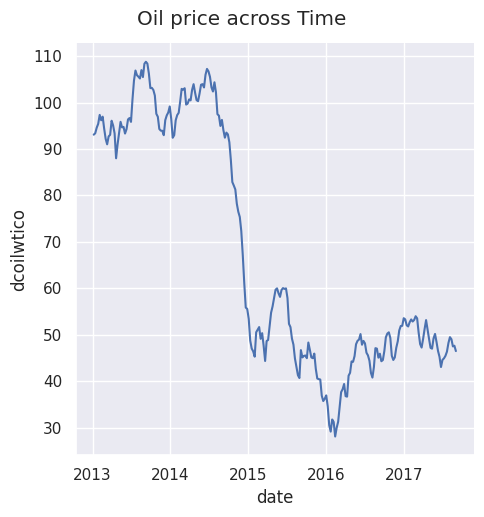

In [36]:
sns.set(rc={'figure.figsize':(12,12)})

resampled_data = oil.resample('W', on='date').mean()
g = sns.relplot(x="date", y="dcoilwtico", data=resampled_data, kind="line")

g.fig.suptitle("Oil price across Time", y=1.03)
plt.show()

### MIssing Days if Any

In [37]:
from datetime import date
import numpy as np

d0 = np.sort(oil['date'])[0]
d1 = np.sort(oil['date'])[-1]
delta = d1 - d0
no_of_days = oil['date'].nunique()
print('The number of days between the given range of dates is :')
print(delta.astype('timedelta64[D]')+1)
print(no_of_days)

The number of days between the given range of dates is :
1704 days
1218


In [38]:
d1

numpy.datetime64('2017-08-31T00:00:00.000000000')

### Find the missing Dates

In [39]:
pd.date_range(start=d0, end=d1).difference(oil['date'].unique())

DatetimeIndex(['2013-01-05', '2013-01-06', '2013-01-12', '2013-01-13',
               '2013-01-19', '2013-01-20', '2013-01-26', '2013-01-27',
               '2013-02-02', '2013-02-03',
               ...
               '2017-07-29', '2017-07-30', '2017-08-05', '2017-08-06',
               '2017-08-12', '2017-08-13', '2017-08-19', '2017-08-20',
               '2017-08-26', '2017-08-27'],
              dtype='datetime64[ns]', length=486, freq=None)

In [40]:
oil.set_index("date", inplace=True)
oil=oil.asfreq('d')
oil=oil.fillna(method='ffill')

#### Conclusion
- oil prices are unavailable on weekends
- Use ffill to fill oil prices for weekends

In [41]:
from datetime import date
import numpy as np

d0 = np.sort(oil.index)[0]
d1 = np.sort(oil.index)[-1]
delta = d1 - d0
no_of_days = oil.index.nunique()
print('The number of days between the given range of dates is :')
print(delta.astype('timedelta64[D]')+1)
print(no_of_days)

The number of days between the given range of dates is :
1704 days
1704


### Correlation between Oil & Sales

In [42]:
oil_sales = pd.DataFrame(train.groupby('date')['sales'].sum()).merge(oil, how='inner', left_index=True, right_index=True)

In [43]:
oil_sales.corr()

,sales,dcoilwtico
sales,1.000000,-0.626856
dcoilwtico,-0.626856,1.000000


#### Conclusion: Negative Correlation on oil prices and Sum of Sales on a given day

### holidays_events.csv

- Holidays and Events, with metadata
**NOTE**: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

- Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

- Additional Notes
 - Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
 - A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

In [44]:
holidays = pd.read_csv('holidays_events.csv', parse_dates=['date'])
holidays.dtypes

date           datetime64[ns]
type                   object
locale                 object
locale_name            object
description            object
transferred              bool
dtype: object

In [45]:
holidays.type.unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [46]:
holidays[holidays['description']=="Independencia de Guayaquil"]


,date,type,locale,locale_name,description,transferred
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
190,2015-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,False
274,2016-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,False
331,2017-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,False


### Event, Holidays that are not transferred, Additional & Bridge are marked as holidays

In [47]:
holidays['is_holiday'] = np.where((holidays['transferred']) | (holidays['type']=='Work Day') , 0, 1)

In [48]:
holidays[holidays['description']=="Independencia de Guayaquil"]


,date,type,locale,locale_name,description,transferred,is_holiday
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True,0
72,2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True,0
135,2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True,0
190,2015-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,False,1
274,2016-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,False,1
331,2017-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,False,1


In [49]:
locale_array = {}
for item in holidays.locale_name.unique():
    if item == 'Ecuador':
        locale_array[item]='All'
    elif item in stores.city.unique():
        locale_array[item]='City'
    elif item in stores.state.unique():
        locale_array[item]='State'
    else:
        locale_array[item]="None of the Above"

In [50]:
locale_array

{'Manta': 'City',
 'Cotopaxi': 'State',
 'Cuenca': 'City',
 'Libertad': 'City',
 'Riobamba': 'City',
 'Puyo': 'City',
 'Guaranda': 'City',
 'Imbabura': 'State',
 'Latacunga': 'City',
 'Machala': 'City',
 'Santo Domingo': 'City',
 'El Carmen': 'City',
 'Cayambe': 'City',
 'Esmeraldas': 'City',
 'Ecuador': 'All',
 'Ambato': 'City',
 'Ibarra': 'City',
 'Quevedo': 'City',
 'Santo Domingo de los Tsachilas': 'State',
 'Santa Elena': 'State',
 'Quito': 'City',
 'Loja': 'City',
 'Salinas': 'City',
 'Guayaquil': 'City'}

## Transactions

In [51]:
transactions = pd.read_csv('transactions.csv', parse_dates=['date'])
transactions.dtypes

date            datetime64[ns]
store_nbr                int64
transactions             int64
dtype: object

In [52]:
transactions.tail()

,date,store_nbr,transactions
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932
83487,2017-08-15,54,802


### Dependence on Payday

In [53]:
payday = pd.read_csv('train.csv', parse_dates=['date'])
payday.dtypes

id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dtype: object

In [54]:
import datetime 
def is_payday(dt):
    todays_month = dt.month
    tomorrows_month = (dt + datetime.timedelta(days=1)).month
    return int((tomorrows_month != todays_month) | (dt.day==15))

In [55]:
payday['is_payday'] = payday['date'].apply(is_payday)

In [56]:
payday[payday['date']=='2013-01-31']

,id,date,store_nbr,family,sales,onpromotion,is_payday
53460,53460,2013-01-31,1,AUTOMOTIVE,0.000,0,1
53461,53461,2013-01-31,1,BABY CARE,0.000,0,1
53462,53462,2013-01-31,1,BEAUTY,2.000,0,1
53463,53463,2013-01-31,1,BEVERAGES,889.000,0,1
53464,53464,2013-01-31,1,BOOKS,0.000,0,1
...,...,...,...,...,...,...,...
55237,55237,2013-01-31,9,POULTRY,335.215,0,1
55238,55238,2013-01-31,9,PREPARED FOODS,42.000,0,1
55239,55239,2013-01-31,9,PRODUCE,0.000,0,1
55240,55240,2013-01-31,9,SCHOOL AND OFFICE SUPPLIES,0.000,0,1


# Building Simple Multiple Regression Model
- Build 1782 models 
- Model will depend on holiday(includes weekend), oil price & payday

In [57]:
df_train = pd.read_csv(
    'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

## Impute missing values
df_new = pd.DataFrame()

for store_nbr in df_train.store_nbr.unique():
    for family in df_train.family.unique():
        df_1_1 = df_train[(df_train['store_nbr']==store_nbr) & (df_train['family']==family)]
        
        df_1_1 = df_1_1.set_index('date')
        df_1_1 = df_1_1.asfreq('D', method='bfill')
        
        df_new = pd.concat([df_new, df_1_1])
        
        
df_train = df_new.reset_index()

## Payday Feature
import datetime 
def is_payday(dt):
    todays_month = dt.month
    tomorrows_month = (dt + datetime.timedelta(days=1)).month
    return int((tomorrows_month != todays_month) | (dt.day==15))

df_train['is_payday'] = df_train['date'].apply(is_payday)

df_train['is_weekend'] = np.where(df_train['date'].dt.weekday < 5, 0, 1)

df_train.head()

,date,store_nbr,family,sales,is_payday,is_weekend
0,2013-01-01,1,AUTOMOTIVE,0.0,0,0
1,2013-01-02,1,AUTOMOTIVE,2.0,0,0
2,2013-01-03,1,AUTOMOTIVE,3.0,0,0
3,2013-01-04,1,AUTOMOTIVE,3.0,0,0
4,2013-01-05,1,AUTOMOTIVE,5.0,0,1


In [58]:
df_holidays = pd.read_csv('holidays_events.csv', parse_dates=['date'])
df_holidays['is_holiday'] = np.where((df_holidays['transferred']) | (df_holidays['type']=='Work Day') , 0, 1)

df_holidays.head()

,date,type,locale,locale_name,description,transferred,is_holiday
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False,1
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,1
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False,1
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False,1
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False,1


In [59]:
df_oil = pd.read_csv('oil.csv', parse_dates=['date'])
df_oil.set_index("date", inplace=True)
df_oil=df_oil.asfreq('d')
df_oil=df_oil.fillna(method='ffill')

df_oil.reset_index(inplace=True)

df_oil=df_oil.fillna(method='bfill')

df_oil.head()

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,93.12


In [60]:
df_stores = pd.read_csv('stores.csv')

locale_array = {}
for item in df_holidays.locale_name.unique():
    if item == 'Ecuador':
        locale_array[item]=[item]
    elif item in stores.city.unique():
        locale_array[item]=[item]
    elif item in stores.state.unique():
        locale_array[item]=[item]
    else:
        locale_array[item]=[None]
        
def mapping_terr(place):
    if place not in locale_array:
        return ''
    else:
        return locale_array[place]



In [61]:
df_mapping_file = pd.DataFrame(locale_array)
df_mapping_file = df_mapping_file.transpose()

df_mapping_file.columns=['place']
df_mapping_file

,place
Manta,Manta
Cotopaxi,Cotopaxi
Cuenca,Cuenca
Libertad,Libertad
Riobamba,Riobamba
Puyo,Puyo
Guaranda,Guaranda
Imbabura,Imbabura
Latacunga,Latacunga
Machala,Machala


In [62]:
df_temp_2=df_stores.merge(df_mapping_file, how='left', left_on='city', right_index=True)
df_temp_2.head()

,store_nbr,city,state,type,cluster,place
0,1,Quito,Pichincha,D,13,Quito
1,2,Quito,Pichincha,D,13,Quito
2,3,Quito,Pichincha,D,8,Quito
3,4,Quito,Pichincha,D,9,Quito
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4,Santo Domingo


In [63]:
df_temp_3=df_stores.merge(df_mapping_file, how='left', left_on='state', right_index=True)
df_temp_3.head()

,store_nbr,city,state,type,cluster,place
0,1,Quito,Pichincha,D,13,NaN
1,2,Quito,Pichincha,D,13,NaN
2,3,Quito,Pichincha,D,8,NaN
3,4,Quito,Pichincha,D,9,NaN
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4,Santo Domingo de los Tsachilas


In [64]:
df_temp = df_stores
df_temp['place']='Ecuador'

df_store_mapping = pd.concat([df_temp_2, 
                              df_temp_3,
                              df_temp], ignore_index=True)

In [65]:
df_store_mapping = df_store_mapping[df_store_mapping['place'].notna()]


In [66]:
df_holidays_store = df_holidays[['date', 'is_holiday', 'locale_name']].merge(df_store_mapping,
                                                                             how='left',
                                                                             left_on='locale_name',
                                                                             right_on='place')

In [67]:
df_holidays_store = df_holidays_store[['date', 'is_holiday', 'store_nbr']]

df_holidays_store = df_holidays_store.groupby(['date', 'store_nbr'], as_index=False)['is_holiday'].sum()

df_holidays_store['is_holiday'] = np.where(df_holidays_store['is_holiday']==0, 0, 1)

In [68]:
df_holidays_store.head()

,date,store_nbr,is_holiday
0,2012-03-02,52,1
1,2012-03-02,53,1
2,2012-04-01,12,1
3,2012-04-01,13,1
4,2012-04-12,37,1


In [69]:
df_train_final = df_train.merge(df_holidays_store, how='left', left_on=['date', 'store_nbr'], right_on=['date', 'store_nbr']).merge(df_oil, left_on='date', right_on='date', how='left')

In [70]:
df_train_final.is_holiday = np.where(df_train_final.is_holiday.fillna(0)+df_train_final.is_weekend==0, 0, 1)

In [71]:
df_train_final = df_train_final.drop('is_weekend', axis=1)
df_train_final.head()

,date,store_nbr,family,sales,is_payday,is_holiday,dcoilwtico
0,2013-01-01,1,AUTOMOTIVE,0.0,0,0,93.14
1,2013-01-02,1,AUTOMOTIVE,2.0,0,0,93.14
2,2013-01-03,1,AUTOMOTIVE,3.0,0,0,92.97
3,2013-01-04,1,AUTOMOTIVE,3.0,0,0,93.12
4,2013-01-05,1,AUTOMOTIVE,5.0,0,1,93.12


In [72]:
df_train_final[df_train_final['date']=='2013-01-02']

,date,store_nbr,family,sales,is_payday,is_holiday,dcoilwtico
1,2013-01-02,1,AUTOMOTIVE,2.000000,0,0,93.14
1689,2013-01-02,1,BABY CARE,0.000000,0,0,93.14
3377,2013-01-02,1,BEAUTY,2.000000,0,0,93.14
5065,2013-01-02,1,BEVERAGES,1091.000000,0,0,93.14
6753,2013-01-02,1,BOOKS,0.000000,0,0,93.14
...,...,...,...,...,...,...,...
2999577,2013-01-02,9,POULTRY,651.291992,0,0,93.14
3001265,2013-01-02,9,PREPARED FOODS,83.000000,0,0,93.14
3002953,2013-01-02,9,PRODUCE,0.000000,0,0,93.14
3004641,2013-01-02,9,SCHOOL AND OFFICE SUPPLIES,0.000000,0,0,93.14


## Production ready predictions

### Making Test Set Ready

In [73]:
df_test = pd.read_csv(
    'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
import datetime 
def is_payday(dt):
    todays_month = dt.month
    tomorrows_month = (dt + datetime.timedelta(days=1)).month
    return int((tomorrows_month != todays_month) | (dt.day==15))

df_test['is_payday'] = df_test['date'].apply(is_payday)

df_test['is_weekend'] = np.where(df_test['date'].dt.weekday < 5, 0, 1)

df_test.head()

,id,date,store_nbr,family,onpromotion,is_payday,is_weekend
0,3000888,2017-08-16,1,AUTOMOTIVE,0,0,0
1,3000889,2017-08-16,1,BABY CARE,0,0,0
2,3000890,2017-08-16,1,BEAUTY,2,0,0
3,3000891,2017-08-16,1,BEVERAGES,20,0,0
4,3000892,2017-08-16,1,BOOKS,0,0,0


In [74]:
df_test_final = df_test.merge(df_holidays_store, how='left', left_on=['date', 'store_nbr'], right_on=['date', 'store_nbr']).merge(df_oil, left_on='date', right_on='date', how='left')
df_test_final.is_holiday = np.where(df_test_final.is_holiday.fillna(0)+df_test_final.is_weekend==0, 0, 1)


df_test_final = df_test_final.drop('is_weekend', axis=1)
df_test_final.head()

,id,date,store_nbr,family,onpromotion,is_payday,is_holiday,dcoilwtico
0,3000888,2017-08-16,1,AUTOMOTIVE,0,0,0,46.8
1,3000889,2017-08-16,1,BABY CARE,0,0,0,46.8
2,3000890,2017-08-16,1,BEAUTY,2,0,0,46.8
3,3000891,2017-08-16,1,BEVERAGES,20,0,0,46.8
4,3000892,2017-08-16,1,BOOKS,0,0,0,46.8


In [75]:
df_train_final['date'] = df_train_final.date.dt.to_period('D')

In [76]:
df_train_final = df_train_final[df_train_final['date']>='2017-01-01'].set_index(['store_nbr', 'family', 'date']).sort_index()

In [77]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression

y = df_train_final.unstack(['store_nbr', 'family'])['sales']

In [78]:
# Create training data

fourier = CalendarFourier(freq='M', order=4)
fourier_1 = CalendarFourier(freq='Y', order=2)

dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier, fourier_1],
    drop=True,
)
X = dp.in_sample()

In [79]:
X=X.merge(df_train_final.reset_index()[['date', 'is_payday', 'dcoilwtico']].drop_duplicates(), how='left', on='date').drop('date',axis=1)

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

In [80]:
datetime_series = pd.Series(
    pd.date_range("2013-01-01", periods=y_pred.shape[0], freq="D")
)

y_pred['date'] = datetime_series
y_pred = y_pred.set_index('date')                                                

In [81]:
# Create features for test set
X_test = dp.out_of_sample(steps=16)

X_test.index.name = 'date'

X_test.index = X_test.index.astype(np.datetime64)

In [82]:
X_test=X_test.merge(df_test_final[['date', 'is_payday', 'dcoilwtico']].drop_duplicates(), how='left', on='date').set_index('date')

X_test.index = X_test.index.to_period('D')

df_test_final['date'] = df_test_final.date.dt.to_period('D')
df_test_final = df_test_final.set_index(['store_nbr', 'family', 'date']).sort_index()

In [83]:
y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

In [84]:
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.reset_index()
y_submit.columns = ['date', 'store_nbr', 'family', 'sales']

In [85]:
y = y.stack(['store_nbr', 'family'])
y = y.reset_index()
y.columns = ['date', 'store_nbr', 'family', 'sales']

In [86]:
all_df = pd.concat([y, y_submit])

In [87]:

def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store_nbr", "family"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

def lag_features(df, lags):
    for lag in lags:
        df[f"sales_t-{lag}"] = df.groupby(["store_nbr", "family"])["sales"].transform(
            lambda x: x.shift(lag))
    return df

def lead_features(df, leads):
    for lead in leads:
        df[f"sales_t+{lead}"] = df.groupby(["store_nbr", "family"])["sales"].transform(
            lambda x: x.shift(-lead))
    return df


all_df = lag_features(all_df, lags = [*range(1, 16), 16,17,18,19,20,21,22,30,31,90,180,364])

#all_df = lag_features(all_df, lags = [1,2,3,7,30])

all_df = lead_features(all_df, leads = [1,7])

alphas = [0.95, 0.9, 0.8, 0.5]

#alphas = [0.95, 0.5]
lags =[1,7]
all_df = ewm_features(all_df, alphas, lags)

In [88]:
from xgboost import XGBRegressor
# from sklearn.multioutput import RegressorChain

model = XGBRegressor(alpha=10, eta=0.5, gamma=20, max_depth=4)

start_date='2017-08-16'
end_date='2017-08-31'

train = all_df[all_df['date'] < start_date].set_index(['date','store_nbr', 'family']).sort_index().iloc[:, 1:]
y =  all_df[all_df['date'] < start_date].set_index(['date','store_nbr', 'family']).sort_index().iloc[:,0]


test = all_df[all_df['date'] >= start_date].set_index(['date','store_nbr', 'family']).sort_index().iloc[:,1:]
        
y_final = model.fit(train, y)




In [89]:
final = pd.DataFrame(model.predict(test), index=test.index)

In [90]:
final

0
date       store_nbr family                                 
2017-08-16 1         AUTOMOTIVE                     2.456125
                     BABY CARE                      2.456125
                     BEAUTY                         2.456125
                     BEVERAGES                   2459.648438
                     BOOKS                          2.456125
...                                                      ...
2017-08-31 9         POULTRY                      226.225708
                     PREPARED FOODS                15.311769
                     PRODUCE                      683.049622
                     SCHOOL AND OFFICE SUPPLIES   127.255882
                     SEAFOOD                       16.996622

[28512 rows x 1 columns]

In [91]:
final.columns=['sales']

df_test = df_test.reset_index()
df_test.date = df_test.date.astype('datetime64[ns]')

final = final.reset_index()
final.date = final.date.astype('datetime64[ns]')

final_file = df_test.merge(final, on=['date','store_nbr', 'family'])[['id','sales']]

In [92]:
final_file = final_file.clip(0.0)

In [93]:
final_file.to_csv('submission_kaggle_way_4.csv', index=False)

In [94]:
all_df['date']=all_df['date'].astype(np.datetime64)



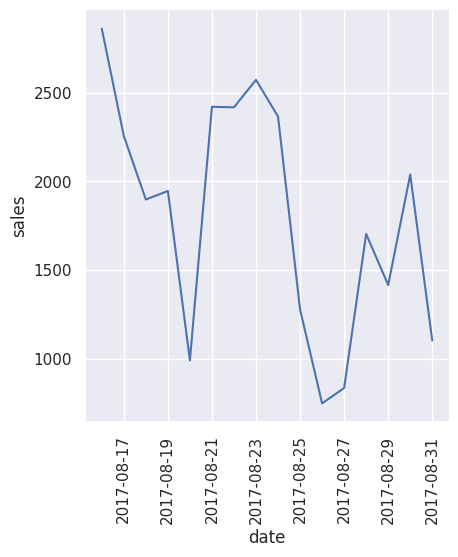

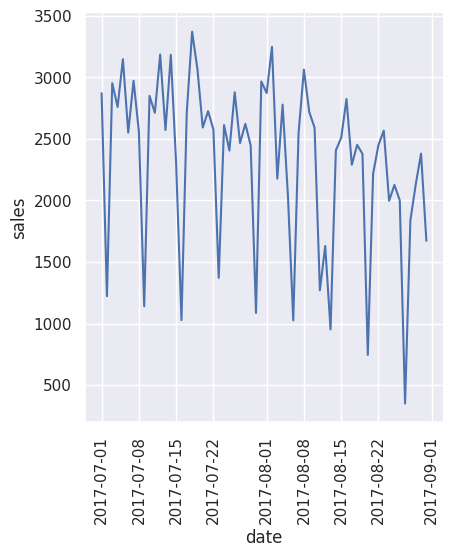

In [95]:
x=final.reset_index()

sns.relplot(data=x[(x['date']>='2017-08-16') & (x['store_nbr']=='1') & (x['family']=='GROCERY I')], x='date', y='sales', kind='line')
plt.xticks(rotation=90)

sns.relplot(data=all_df[(all_df['date']>='2017-07-01') & (all_df['store_nbr']=='1') & (all_df['family']=='GROCERY I')], x='date', y='sales', kind='line')
plt.xticks(rotation=90)
plt.show()

In [96]:
df_train[(df_train['is_weekend']==0) & (df_train['store_nbr']=='1') & (df_train['family']=='GROCERY I')]['sales'].mean()

2440.0107